# 🩺 Project 1 – Synthetic Medical Tabular Data
  
  Objectives:  
1. Load a public medical dataset (Pima Indians Diabetes).  
2. Use a GAN to generate **synthetic patients**.  
3. Compare statistical distributions (real vs. synthetic).  
4. Evaluate the impact on a predictive model (Logistic Regression).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

## 2. Load and explore dataset
We use the **Pima Indians Diabetes** dataset 

In [12]:
df = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")
print(df.head())
print(df.shape)


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
(768, 9)


### Dataset description


In [13]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- **768 patients** 
- Features:
   we have 9 numeric feature: Age, Glucose, Blood Pressure, BMI, DiabetesPedigreeFunction, Age, Outcome
- Target: `Outcome` (0 = no diabetes, 1 = diabetes)

## 3. Preprocessing
- Normalize features
- Split Features / Target

In [14]:
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


## 4. GAN implementation
- **Generator**: creates synthetic patients from random noise.  
- **Discriminator**: distinguishes real vs. synthetic patients.

In [15]:
latent_dim = 16
data_dim = X_tensor.shape[1]

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, data_dim)
        )
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Initialize
generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

criterion = nn.BCELoss()

dataloader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)


## 5. Train the GAN

In [16]:
epochs = 50

for epoch in range(epochs):
    for real_batch, in dataloader:
        batch_size = real_batch.size(0)
        
        # Real and fake labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # ----------------- Discriminator -----------------
        optimizer_D.zero_grad()
        outputs_real = discriminator(real_batch)
        d_loss_real = criterion(outputs_real, real_labels)
        
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        outputs_fake = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        # ----------------- Generator -----------------
        optimizer_G.zero_grad()
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")


Epoch 10/50 | D_loss: 1.5639 | G_loss: 0.5362
Epoch 20/50 | D_loss: 0.9202 | G_loss: 1.6398
Epoch 30/50 | D_loss: 0.5481 | G_loss: 1.6523
Epoch 40/50 | D_loss: 1.3858 | G_loss: 1.8097
Epoch 50/50 | D_loss: 1.6279 | G_loss: 0.6742


## 6. Generate synthetic patients

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


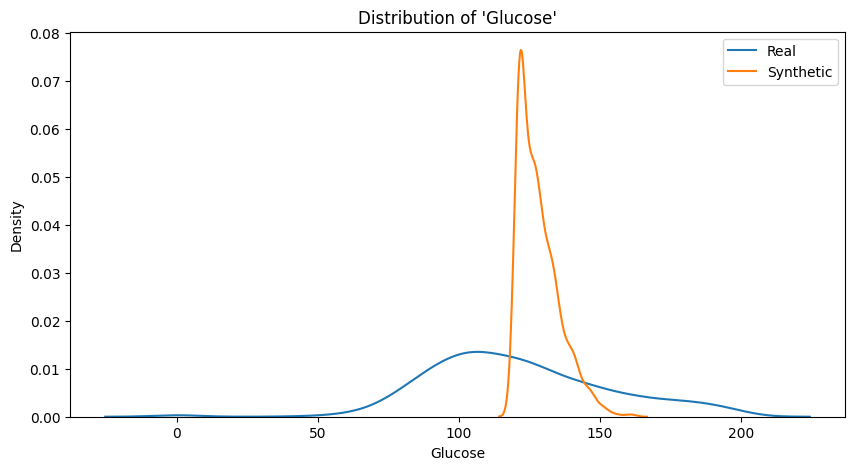

In [17]:
z = torch.randn(1000, latent_dim)
synthetic_data = generator(z).detach().numpy()

synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)

real_df = pd.DataFrame(X, columns=df.columns[:-1])
synth_df = pd.DataFrame(synthetic_data_rescaled, columns=df.columns[:-1])

# Compare distributions
plt.figure(figsize=(10,5))
sns.kdeplot(real_df["Glucose"], label="Real")
sns.kdeplot(synth_df["Glucose"], label="Synthetic")
plt.title("Distribution of 'Glucose'")
plt.legend()
plt.show()


🔹 Observations

Synthetic distribution is very narrow:

Almost all synthetic Glucose values are between ~120–150.

The real data has a much wider range (~50–220), showing more variability.

Peaks mismatch:

The synthetic data is sharply peaked around ~125–130.

Real data is flatter, with multiple densities across the range.

GAN did not capture extremes:

No synthetic patients with very low (<70) or very high (>180) Glucose.

This is typical when training a GAN on a small dataset or with unstable training as it is mentioned at the previous training results


## 7. Predictive experiment (Logistic Regression)
We compare:
- **Baseline model**: trained on real data only  
- **Augmented model**: trained on real + synthetic data

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Baseline
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline AUC:", roc_auc_score(y_test, y_pred))

# Augmented (synthetic with random labels)
y_synth = np.random.choice([0,1], size=synthetic_data.shape[0])
X_aug = np.vstack([X_train, synthetic_data])
y_aug = np.hstack([y_train, y_synth])

clf_aug = LogisticRegression(max_iter=500)
clf_aug.fit(X_aug, y_aug)
y_pred_aug = clf_aug.predict(X_test)
print("Augmented Accuracy:", accuracy_score(y_test, y_pred_aug))
print("Augmented AUC:", roc_auc_score(y_test, y_pred_aug))


Baseline Accuracy: 0.7359307359307359
Baseline AUC: 0.7098509933774835
Augmented Accuracy: 0.7012987012987013
Augmented AUC: 0.6862996688741722


#### Observations

Performance drops when adding synthetic data with random labels.

Accuracy and AUC are both lower for the augmented model.

This is expected because the synthetic labels are completely random. Logistic Regression is trying to learn patterns, but random labels introduce noise, which confuses the model.

Why the baseline is better?

The baseline sees only real, correctly labeled data, so it can learn meaningful relationships.

Adding randomly labeled data dilutes the signal and harms performance.

**Conclusion:**

Simply adding synthetic data without ensuring label quality can decrease model performance.

Synthetic data is only helpful if it is representative of the real data distribution and has accurate labels.